<div style="width: 100%; clear: both; font-family: Verdana;">
<div style="float: left; width: 50%;font-family: Verdana;">
<img src="https://github.com/Eligoze/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo1.png" align="left">
</div>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exploratory Data Analysis
## Ciclo de vida de elementos de inventario.
### Axity - AT&T.

## Descripción
Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. Se creará un EDA enfocado a la salida de almacén. Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. La fuente que corresponde a este análisis es:

* **Salida de Almacén (WLOG)**

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [2]:
conf = SparkConf().setAppName('Segregacion')  \
    .setMaster('yarn') 
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20,Category20c_19
output_notebook()

Loading BokehJS ...

### Recolección de los datos: 

*IMPORTANTE*: Si se requieren ver datos de otro periódo, se debe cambiar los filtros ```year = <año-a-ejecutar>```, ```month = <mes-a-ejecutar>```, ```day = <día-a-ejecutar>``` de las tablas en la creación del dataframe.

#### Reglas para serie con pyspark:
Sobre el df que se carga con pyspark, se le agrega una columna con el nombre de serie_cleaned. el cual contiene valores 0 y 1.

Se crea el dataframe de spark

In [4]:
df_load=spark.sql("SELECT * FROM tx_wlog").cache()

In [5]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",u'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    str_temp = string.encode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 1
    elif len(str_temp) < 6:
      return 1
    elif any(ext in str_temp.upper()for ext in search_list):
      return 1
    else:
      return 0

Se crea un udf en spark sobre la funcion ya creada 

In [6]:
validate_rule_udf = udf(validate_rule, IntegerType())

Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.

In [7]:
df_serie = df_load.withColumn("serie_cleaned",validate_rule_udf(col("serie"))).cache()

Se convierte el dataframe de spark a un dataframe de pandas 

In [8]:
df = df_serie.toPandas()

Hemos recolectado los campos a analizar de las fuente wlog.

## Salida de Almacén WLOG
Una muestra de la fuente WLOG

In [9]:
df.head(5)

,id,organizacion,lpn_salida,num_pedido_att,num_pedido,sku_oracle,sku_descripcion,serie,activo,parte,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,1192917,2PX,MEX6516341261058730EMB,65163412,P2019111320193,T.9047112,MODEM-EA,164964,NA,NA,...,6040e0fbcc34b85f6314be26e9e89e232d94b2a7b4f89c...,Salida de Almacen,2019:111:02:18:28:17,tx_wlog_embarques,20191202,delete,2019,11,28,0
1,1196556,2PX,MEX6522697561058835EMB,65226975,P2019111520352,W.9047309,BGK90160/1 O&M ADAPTER FOR CABLE,NA,NA,NA,...,b69e82e4a533194f6e78ba0c96b6d6be9cc0e4e5ea0243...,Salida de Almacen,2019:111:02:18:28:17,tx_wlog_embarques,20191202,delete,2019,11,28,1
2,1197110,2PX,MEX6522697561058835EMB,65226975,P2019111520352,W.9047311,NTK102260/10 CLAMP 4.8/8.3MM 10 PCS,NA,NA,NA,...,0598c6e028a0daf45d7b19df7adc3fb70fb09055322153...,Salida de Almacen,2019:111:02:18:28:17,tx_wlog_embarques,20191202,delete,2019,11,28,1
3,1197826,2PX,MEX6531997061059129EMB,65319970,P2019112020418,T.3402996,IUSA-FH NYLON CABLE TIES,NA,NA,NA,...,83f2d2fe5ee2ed6c337ba0f4fec0a0d9feef62c8827855...,Salida de Almacen,2019:111:02:18:28:17,tx_wlog_embarques,20191202,delete,2019,11,28,1
4,1199435,2PX,MEX6532605761059419EMB,65326057,P2019112220515,W.1011018,TARJETA DE APERTURA ELECTRICA BLUETOOTH MX5,NA,01185632,NA,...,bc55c2018f5d47048ac7b44ee6355dea97d2a4c72a1675...,Salida de Almacen,2019:111:02:18:28:17,tx_wlog_embarques,20191202,delete,2019,11,28,1


### Diccionario de datos.
A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

* **id**: ID identificador de registros consecutivo.
* **organizacion**: Código que identifica sitios de almacén.
* **lpn_salida**: Código que identifica a los pallets en la salida de almacén.
* **num_pedido_att**: Código de número de pedido ATT.
* **num_pedido**: Código de númoer de pedido ATT.
* **sku_oracle (article)**: Identificador único de artículo en Oracle.
* **sku_descripcion (descripción)**: Descripción del identificador único de artículo en Oracle.
* **series**: Número de serie único que tiene el proveedor.
* **activo**: Id único del elemento de red en AT&T.
* **parte**: Código que identifica partes del elemento.
* **quantity**: Cantidad de elementos.
* **units**: Unidad de medida de conteo de los elementos.
* **area_usuaria**: Área usuaria.
* **control_serie**: Bandera que indica si existe o no número de serie.
* **control_activo**: Bandera que indica si el activo está con vida o ha sido retirado.
* **site_name**: Nombre del sitio.
* **site_id**: Código del sitio.
* **proyecto**: Nombre del Proyecto.
* **orden_compra**: Código de la orden de compra.
* **tipo_transporte**: A quién pertenece el trasporte de carga.
* **audit_cierre_embarque**: Fecha de salida de almacén hacía el embarque.
* **filedate**: Fecha de carga del archivo fuente.
* **filename**: Nombre del archivo fuente.
* **hash_id**: Identificador único hash de la fuente.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre indentificador de la fuente.
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de registro.
* **year**: Año de la partición.
* **month**: Mes de la partición.
* **day**: Día de la partición.

### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [10]:
camposwlog=df.columns
print 'Columnas de la fuente WLOG son: ',list(camposwlog)
pd.DataFrame(df.dtypes,columns=['Tipo de objeto WLOG'])

Columnas de la fuente WLOG son:  ['id', 'organizacion', 'lpn_salida', 'num_pedido_att', 'num_pedido', 'sku_oracle', 'sku_descripcion', 'serie', 'activo', 'parte', 'cantidad', 'units', 'area_usuaria', 'control_serie', 'control_activo', 'site_name', 'site_id', 'proyecto', 'orden_compra', 'tipo_transporte', 'audit_cierre_embarque', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie_cleaned']


,Tipo de objeto WLOG
id,object
organizacion,object
lpn_salida,object
num_pedido_att,object
num_pedido,object
sku_oracle,object
sku_descripcion,object
serie,object
activo,object
parte,object


In [11]:
print 'renglones = ',df.shape[0],' columnas = ',df.shape[1]

renglones =  17741  columnas =  33


In [12]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes=[v for v in df.columns if v not in NOrelevantes]

df[relevantes].describe(include='all')

,id,organizacion,lpn_salida,num_pedido_att,num_pedido,sku_oracle,sku_descripcion,serie,activo,parte,...,area_usuaria,control_serie,control_activo,site_name,site_id,proyecto,orden_compra,tipo_transporte,audit_cierre_embarque,serie_cleaned
count,17741,17741,17741,17741,17741,17741,17741,17741,17741,17741,...,17741,17741,17741,17741,17741,17741,17741,17741,17741,17741.000000
unique,4587,1,803,671,206,423,383,1544,1673,111,...,25,17,27,512,527,78,22,20,656,NaN
top,1193260,2PX,MEX6522708161059104EMB,65227081,P2019112220515,CW.9056368,null,NA,NA,NA,...,ATT INFRA,NO,NO,null,null,Chapas Electronicas,NA,PROVEEDOR,November- 25 2019 23:50:12,NaN
freq,8,17741,632,728,2880,1504,2393,12502,10101,15531,...,7173,10399,8313,2393,2393,2880,15083,7045,728,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.734457
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441634
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Podemos notar que hay solamente una organización, esta es **2PX**. Además, podemos ver como posibilidad, catálogos para **units, area_usuaria, control_serie, control_activo y tipo_transporte**.
* Después de dar una revisión a fondo a **control_activo** y **control_serie** se observó que necesita fuertes reglas de calidad, es debido a la falta de estas, que presenta varios valores únicos, cuando la naturaleza de este campo sería ser booleano.
* **sku_descripcion** necesita tratamiento de nulos, mismo aplica para **serie, activo, site_name, site_id y orden_compra**.

#### Se propone un catálogo derivado de la fuente WLOG con los siguientes campos:
    
* **site_id**: Código identificador del sitio.
* **area_usuaria**: Área.
* **tipo_transporte**: A quién pertenece el trasporte de carga.
* **units**: Formato de la medida de conteo de los elementos.

Este catálogo nos ayudará a mapear todos los diferentes proyectos que existen en los cuales hay un activo. A continuación se indican los únicos de cada campo:


### 3. Exploración de los datos.
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas, de manera particular nos enfocaremos en los catálogos.

#### Para empezar, se hará una limpieza general a los datos:

In [9]:
df.replace('null',np.NaN,inplace=True)
df.replace('NA',np.NaN,inplace=True)

### Primer catálogo: *site_id*

Empezaremos con el catálogo de códigos de sitio. Siendo un catálogo muy grande, aplicaremos una normalización a los datos para poder trabajarlos. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

In [14]:
#Se hace catálogo:
ind=list(range(0,20))
principales=pd.DataFrame(df.site_id.value_counts()[:20])
sitecodes=principales.index
sitecodes=pd.DataFrame(sitecodes,index=ind)
sitecodes.columns=['Sitecodes']
principales.index=ind
principales.columns=['Frecuencias']

principales=pd.concat([sitecodes,principales],axis=1)

medios=df.site_id.value_counts()[20:70].sum()
Otros=df.site_id.value_counts()[70:].sum()

Medios=pd.DataFrame({'Sitecodes':'Medios','Frecuencias':medios},index=[0])
Otros=pd.DataFrame({'Sitecodes':'Otros','Frecuencias':Otros},index=[0])

Total=pd.concat([principales,Medios,Otros])
Total.reset_index(inplace=True,drop=True)
First=Total.Sitecodes[0]
Total

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Frecuencias,Sitecodes
0,360,VER-7087
1,352,PUE-7021
2,312,MEX-9049
3,276,TAMREY2169
4,240,Solicitud Interna
5,240,HMAZ0017
6,240,HMAZ0011
7,180,VER-7131
8,176,HMEX8061
9,176,HMEX0540


Después de hacer una normalización del catálogo ahora podemos hacer la visualización más adecuada.
Empezaremos usando un Histograma.

Text(0.5,1,'Frecuencia de sitios en WLOG')

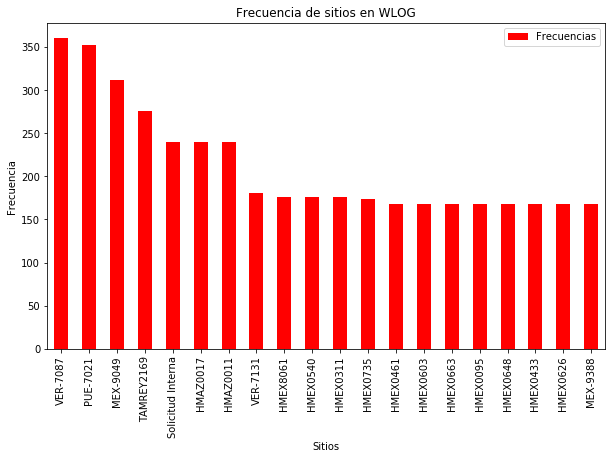

In [15]:
principales_aux=principales.set_index('Sitecodes')
principales_aux.plot(kind='bar',figsize=(10,6),rot=90,colormap='rainbow_r')
plt.xlabel('Sitios')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de sitios en WLOG')

Ahora representamos los mismos datos pero con un gráfico tipo piechart.

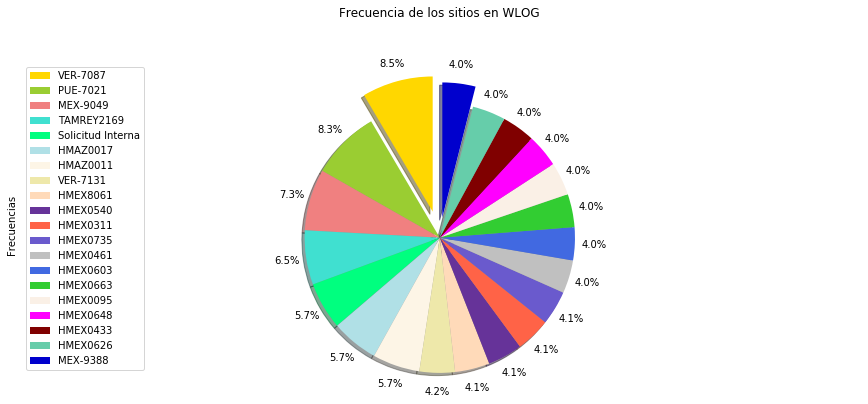

In [16]:
color_list=['gold','yellowgreen','lightcoral','turquoise',
            'springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','royalblue','limegreen',
            'linen','magenta','maroon','mediumaquamarine','mediumblue','mediumorchid',
            'mediumpurple','mediumseagreen']
explode_list=[0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.15]
principales_aux['Frecuencias'].plot(kind='pie',
                    figsize=(15,6),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                    explode=explode_list)
plt.title('Frecuencia de los sitios en WLOG',y=1.12)
plt.axis('equal')
plt.legend(labels=principales_aux.index,loc='upper left')

plt.show()


Hay una gran diversidad de sitios, siendo el más poblado:           

In [17]:
print First

VER-7087


Una vez visto esto, recomendamos que en futuras visualizaciones y estudios a este catálogo, siempre se haga una normalización.

### Segundo catálogo: *area_usuaria*.
Seguimos el mismo procedimiento, pero para este caso no es necesario normalizar.

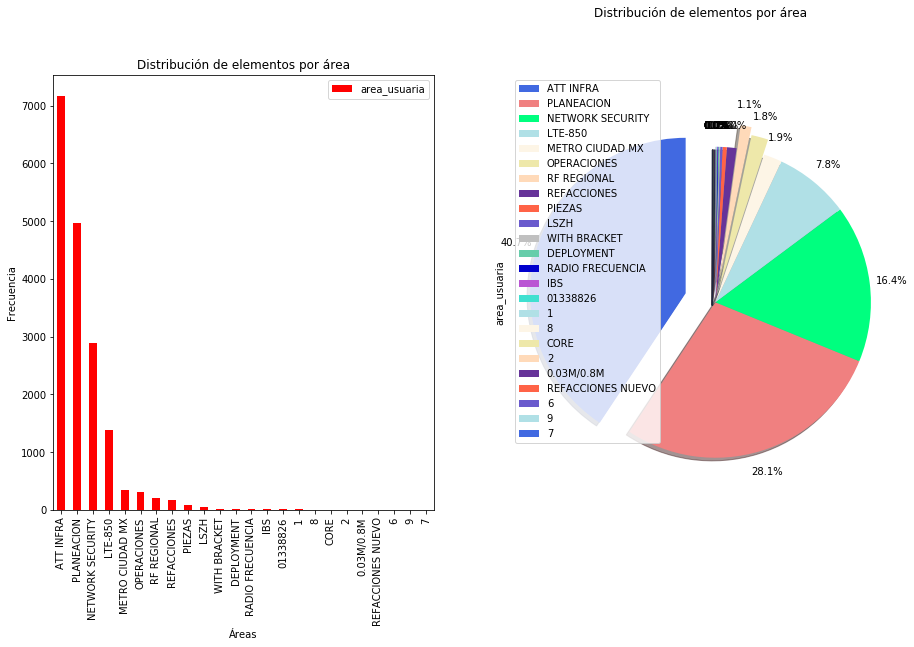

In [18]:
#Revisamos frecuencias:
areas=pd.DataFrame(df.area_usuaria.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
areas.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Áreas')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de elementos por área')

#Subplot2: Bar chart
explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

areas['area_usuaria'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de elementos por área',y=1.12)
ax1.axis('equal')
ax1.legend(labels=areas.index,loc='upper left')

plt.show()

Podemos observar en primer lugar, que se necesitan reglas de limpieza, existen outliers que al parecer son datos sucios.
Se llamará al catálogo limpio en el apartado de catálogos.

### Tercer catálogo: *tipo_transporte*.

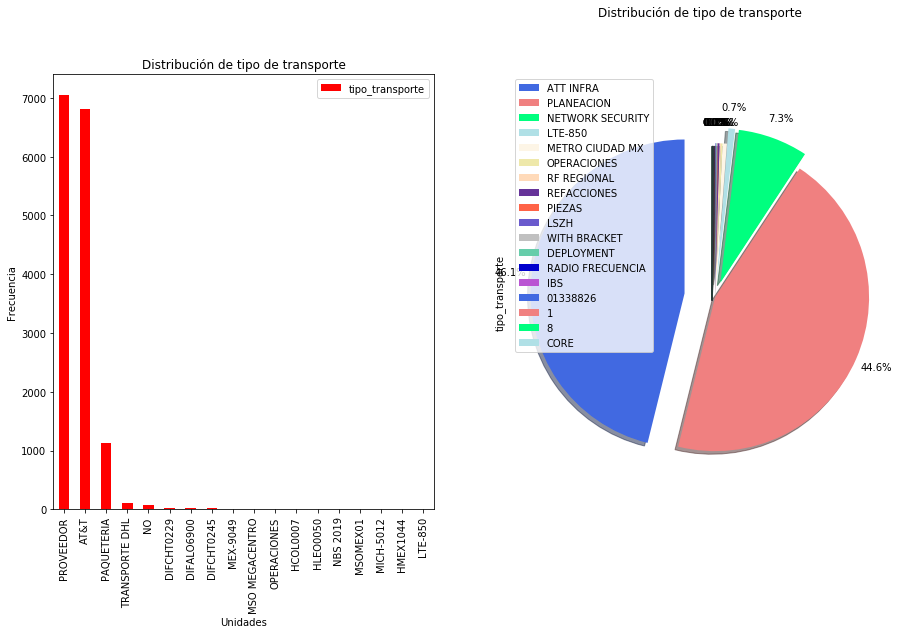

In [19]:
#Revisamos frecuencias:
trasportes=pd.DataFrame(df.tipo_transporte.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
trasportes.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Unidades')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de tipo de transporte')

#Subplot2: Bar chart
explode_list=[.2,0,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid']

trasportes['tipo_transporte'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de tipo de transporte',y=1.12)
ax1.axis('equal')
ax1.legend(labels=areas.index,loc='upper left')

plt.show()

Hemos identificado que este campo necesitará aclaraciones de parte del negocio. Hay muchos valores que no concuerdan, códigos y nombres. 

### Cuarto catálogo: *units*.


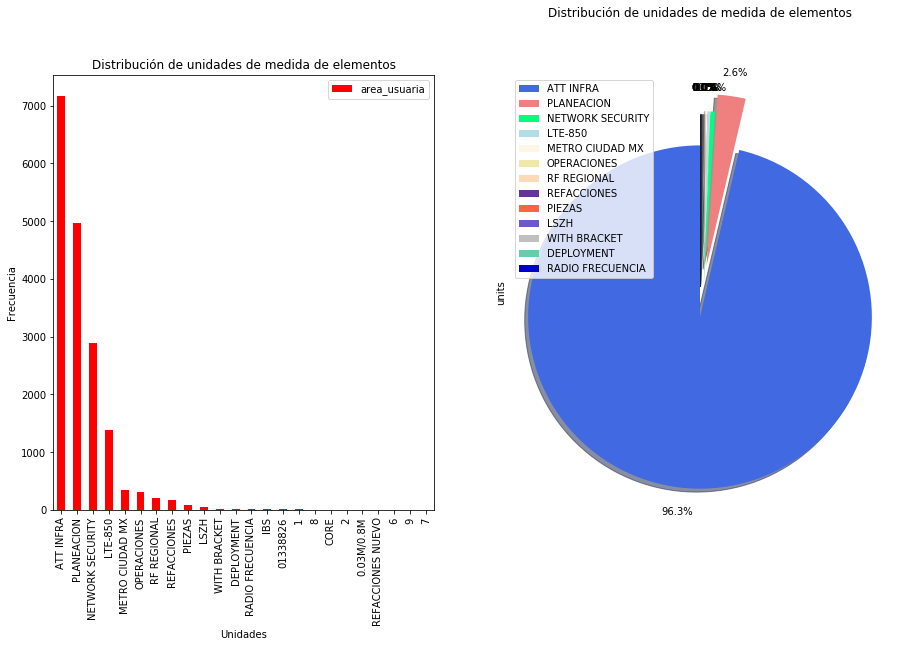

In [20]:
#Revisamos frecuencias:
units=pd.DataFrame(df.units.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
areas.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Unidades')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de unidades de medida de elementos')

#Subplot2: Bar chart
explode_list=[.2,.1,0,0,0,0,0,0,0,0,0,0,0]
color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue']

units['units'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de unidades de medida de elementos',y=1.12)
ax1.axis('equal')
ax1.legend(labels=areas.index,loc='upper left')

plt.show()

Nos encontramos con un problema muy parecido: Encontramos valores atípicos que parecen ser datos sucios. Habrá que pasar reglas de limpieza.  
**No** se hará catálogo de este campo debido a su condición.

#### Visualización de los datos de trazabilidad: 

In [21]:
pd.DataFrame(df.serie.value_counts()[:15])

,serie
850NM,72
0.7M,44
CAPACIDAD NOMINAL DE 500 LTS,43
P/N: ATM200-A20,20
698-960MHZ/4DBI,14
GREY,9
EM184000062320,8
2102352571P0K1000179,8
21021207316TG3902075,8
CAT2332U3EZ,8


In [22]:
pd.DataFrame(df.activo.value_counts()[:15])

,activo
LC,72
BLUE/BLACK,44
1710-2700MHZ/5DBI,14
SILICONE RUBBER,9
01303258,8
01303210,8
01144765,8
01110660,8
01185631,8
01185769,8


In [23]:
pd.DataFrame(df.lpn_salida.value_counts()[:15])

,lpn_salida
MEX6522708161059104EMB,632
MEX6521791761058921EMB,600
MEX6521772161058911EMB,552
MEX6524578561059054EMB,336
MEX6503641361058068EMB,328
MEX6524588561059058EMB,328
MEX6534406461059618EMB,228
MEX6520236261058825EMB,222
MEX6520220361058821EMB,222
MEX6522723061058836EMB,180


In [24]:
pd.DataFrame(df.sku_oracle.value_counts()[:15])

,sku_oracle
CW.9056368,1504
W.6019020,1360
W.1011018,1360
W.1040226,843
W.1013179,441
W.9056071,420
W.1040221,375
W.1040220,299
T.9023243,287
W.4501720,248


In [25]:
pd.DataFrame(df.orden_compra.value_counts()[:15])

,orden_compra
OPERACIONES,58
ATT INFRA,40
ALVARO OBREGON M2925X,24
SEVILLA/RIO NILO 0661MX,24
TROCADERO M2924X,24
METRO CIUDAD MX,21
REFACCIONES,20
EL TRAPICHE,8
Conscripto,8
NO,8


#### Es de interés haber observado los datos que se usaran para la trazabilidad, se han identificado valores sucios y repetidos. 
Podemos utilizar los siguientes queries como ejemplos para visualizar en HUE:
* Activo: `SELECT * FROM tx_wlog WHERE activo=='100% ALGODÓN';` 
* Serie: `SELECT * FROM tx_wlog WHERE serie=='P/N: ATM200-A20';`

### 4. Calidad de los datos.
Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [26]:
Navi=[u'id', u'organizacion', u'lpn_salida', u'num_pedido_att', u'num_pedido',
       u'sku_oracle', u'sku_descripcion', u'serie', u'activo', u'parte',
       u'cantidad', u'units', u'area_usuaria', u'site_name', u'site_id',
      u'proyecto',u'orden_compra', u'tipo_transporte', u'audit_cierre_embarque']

In [27]:
wlog_nas=df[Navi].isna().sum()
porcentaje_wlog_nas=wlog_nas/df[Navi].isna().count()

columnas=list(porcentaje_wlog_nas.keys())
counts_nas=list(porcentaje_wlog_nas.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_19))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_wlog_nas*100,columns=['Porcentaje de NAs'])

,Porcentaje de NAs
id,0.000000
organizacion,0.000000
lpn_salida,0.000000
num_pedido_att,0.000000
num_pedido,0.000000
sku_oracle,0.000000
sku_descripcion,13.488529
serie,70.469534
activo,56.935911
parte,87.542980


#### Visualización de datos NOT NULL WLOG: 

In [28]:
notmiss=(1-porcentaje_wlog_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_19))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

,Porcentaje de Not nulls
id,100.000000
organizacion,100.000000
lpn_salida,100.000000
num_pedido_att,100.000000
num_pedido,100.000000
sku_oracle,100.000000
sku_descripcion,86.511471
serie,29.530466
activo,43.064089
parte,12.457020


Después de visualizar estos porcentajes, podemos observar que la trazabilidad del elemento se vuelve un tema difícil.  
Los campos **series** y **activo** que son usados para la trazabilidad, nos muestran un alto índice de missings.
También observamos que el campo que se considerará para una mejor relación entre as fuentes es **lpn_salida**, **num_pedido_att**, **sku_oracle** y **site_id**.

#### 4.2 Data Errors
* **control_serie**: El campo contiene registros una gran diversidad de datos sucios. Siendo un campo booleano, tiene múltiples valores únicos.
* **control_activo**: El campo contiene registros una gran diversidad de datos sucios. Siendo un campo booleano, tiene múltiples valores únicos.
* **activo**: El campo contiene registros nulos mal identificados: "'NA". Se encontraron valores que no corresponden a este campo. 
* **serie**: El campo contiene registros nulos mal identificados: "'NA". No hay un formato estándar. Hay valores que quedaron con notación científica. Hay muchos valores sucios.
* **site_id**: Se hace la notación de que se encuentra un registro con alta frequencia "*Solicitud interna*".
* **area_usuaria**: Se encuentran valores atípicos y no congruentes.
* **tipo_transporte**: Se encuentran valores atípicos y no congruentes.
* **units**: Se encuentran valores atípicos y no congruentes.

### 5. Catálogos.

#### Catálogo de site_id:

In [29]:
Catalogo_Siteid=pd.DataFrame(df.site_id.unique())
Catalogo_Siteid.columns=['Site_ids']

#Remover los sucios
dirt=['Piezas','PIEZAS']
Catalogo_Siteid=Catalogo_Siteid.loc[Catalogo_Siteid.Site_ids.str.len()>6]
Catalogo_Siteid.replace(dirt,np.NaN,regex=True,inplace=True)
Catalogo_Siteid.dropna(inplace=True)
Catalogo_Siteid.reset_index(drop=True)
Catalogo_Siteid.sort_values(by='Site_ids').head(10)

,Site_ids
443,ACA-002
458,ACA-003
387,ACA-010
406,ACA-013
523,ACA-017
510,ACA-019
58,ACA-MTX
251,AGUAGU1606
504,AGUAGU1654
194,AGUAGU1655


#### Catálogo área usuaria:

In [30]:
Catalogo_areas=areas.head(9)
Catalogo_areas=pd.DataFrame(Catalogo_areas.index)
Catalogo_areas.columns=['Áreas']
Catalogo_areas=Catalogo_areas[(Catalogo_areas['Áreas']!='PIEZAS') & (Catalogo_areas['Áreas']!='LTE-850')]
Catalogo_areas

,Áreas
0,ATT INFRA
1,PLANEACION
2,NETWORK SECURITY
4,METRO CIUDAD MX
5,OPERACIONES
6,RF REGIONAL
7,REFACCIONES


#### Catálogo: *tipo_transporte*

In [31]:
Catalogo_transportes=pd.DataFrame(trasportes.index)
Catalogo_transportes.columns=['Transportes']
Catalogo_transportes=Catalogo_transportes[(Catalogo_transportes.Transportes=='PROVEEDOR') |
                                          (Catalogo_transportes.Transportes=='AT&T') |
                                          (Catalogo_transportes.Transportes=='PAQUETERIA') |
                                          (Catalogo_transportes.Transportes=='TRANSPORTE DHL') |
                                          (Catalogo_transportes.Transportes=='MSO MEGACENTRO') |
                                          (Catalogo_transportes.Transportes=='OPERACIONES')
                                         ]
Catalogo_transportes

,Transportes
0,PROVEEDOR
1,AT&T
2,PAQUETERIA
3,TRANSPORTE DHL
9,MSO MEGACENTRO
10,OPERACIONES


### 6. Preparación de los datos.
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 

* **series**:
    * Tratamiento de missings. 
    * Dar un formato estándar 
    * Revisar valores con notación científica o pasarlos como *NaN* 
    * Revisar datos atípicos, decidir si estos serán marcados como *NaN*.
* **activo**: 
    * Tratamiento de missings 
    * Revisar datos atípicos, decidir si estos serán marcados como *NaN*.
* **quantity**: 
    * Pasar formato a int.
* **units**: 
    * Revisar con negocio cuál será la regla para este campo.
* **area_usuaria**: 
    * Revisar si hay un catálogo existente, de lo contrario, se eliminarían los datos atípicos.
    * Se elimina la palabra *PIEZAS*.
* **control_serie**: 
    * Pasar todos los registros no booleanos a *NaN. Puede ser recuperado tomando como referencia el campo **serie**.
* **control_activo**: 
    * Pasar todos los registros no booleanos a *NaN. Puede ser recuperado tomando como referencia el campo **activo**.
* **site_id**: 
    * Revisar con negocio la regla para los registros *Solicitud interna*.
    * longitud mayor a seis caracteres
    * replace('PIEZAS',np.NaN)
* **orden_compra**: 
    * Revisar si este campo debería ser un código, un booleano o un campo de descripción. Pareciendo más un campo booleano, entonces se propone reemplazar todos los registros sucios por *Si* EN caso de existencia de la PO.
* **tipo_transporte**: 
    * Se busca crear un catálogo. En caso de que no exista uno hecho anteriormente, se propone uno eliminando valores más atípicos.

In [11]:
df_clean=df.copy()

df_clean.site_id.loc[df_clean.site_id.str.len()>6]==np.NaN
df_clean.site_id.replace()

df_clean.area_usuaria.replace('PIEZAS',np.NaN,regex=True,inplace=True)
df_clean.area_usuaria.replace('Piezas',np.NaN,regex=True,inplace=True)
df_clean.area_usuaria.replace('LTE-850',np.NaN,regex=True,inplace=True)
df_clean.replace('vacio',np.NaN,regex=True,inplace=True)

trans_dirt=list(df.tipo_transporte.unique())
trans_clean=['PROVEEDOR','AT&T','PAQUETERIA','TRANSPORTE DHL','MSO MEGACENTRO','OPERACIONES']
trans_dirt=[v for v in trans_dirt if v not in trans_clean]
df_clean.tipo_transporte.replace(trans_dirt,np.NaN,regex=True,inplace=True)

po_clean=list(df.orden_compra.unique())
po_dirt=['vacio','NO','no']
po_clean=[v for v in po_clean if v not in po_dirt]
df_clean.tipo_transporte.replace(po_clean,'SI',regex=True,inplace=True)

#df_clean=df_clean.loc[df_clean.serie_cleaned==0]
df_clean.reset_index(drop=True,inplace=True)
df_clean.head()

,id,organizacion,lpn_salida,num_pedido_att,num_pedido,sku_oracle,sku_descripcion,serie,activo,parte,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,1199829,2PX,MEX6490345261059545EMB,64903452,P2019112120490,T.9023243,ETIQUETA ENROLLABLE AZUL LEYENDA AT&T TAMA?O 4...,NaN,NaN,NaN,...,a8c2f91a3ce0cb608eeb5a7bb26179f0cceeda2c8e76e0...,Salida de Almacen,2019:111:02:17:57:18,tx_wlog_embarques,20191202,insert,2019,11,26,1
1,1194867,2PX,MEX6521791761058921EMB,65217917,P2019111420284,CW.1017039,NaN,NaN,NaN,NTM2012977-2,...,868749ebb8e662b6583fa5fd6f29c81ebd3e3da4c75cd6...,Salida de Almacen,2019:111:02:17:57:18,tx_wlog_embarques,20191202,insert,2019,11,26,1
2,1194850,2PX,MEX6521791761058921EMB,65217917,P2019111420284,CW.9056368,NaN,NaN,NaN,NTAC45840,...,2ce3babc03a21cdf66d3bb53d7ea922e58bfee1e418a7e...,Salida de Almacen,2019:111:02:17:57:18,tx_wlog_embarques,20191202,insert,2019,11,26,1
3,1195310,2PX,MEX6522708161059104EMB,65227081,P2019111420286,CW.1017039,NaN,NaN,NaN,TPM90110-15M,...,904311fbe5af95d85a282cb4b697abd1b1245fed38df2f...,Salida de Almacen,2019:111:02:17:57:18,tx_wlog_embarques,20191202,insert,2019,11,26,1
4,1193216,2PX,MEX6518764961058522EMB,65187649,P2019111420245,W.3410142,JUMPER N-M TO N-M 1M (JP-NM/NM1M-SF12(FR)),NaN,NaN,NaN,...,7a5ed90556fc12f88f8a067db6f6d18c2a0ff13e4d71bb...,Salida de Almacen,2019:111:02:17:57:18,tx_wlog_embarques,20191202,delete,2019,11,26,1


In [16]:
#Trazabilidad
df_clean['trazabilidad']=0
df_clean.trazabilidad.loc[(df_clean.serie_cleaned==0) | (df_clean.activo!=np.NaN)]=1

#CS CA
df_clean['CS_CA']=0
df_clean.CS_CA.loc[(df_clean.serie_cleaned==0) & (df_clean.activo!=np.NaN)]=1

#CS SA
df_clean['CS_SA']=0
df_clean.CS_SA.loc[(df_clean.serie_cleaned==0) & (df_clean.activo==np.NaN)]=1

#SS CA
df_clean['SS_CA']=0
df_clean.SS_CA.loc[(df_clean.serie_cleaned==1) & (df_clean.activo!=np.NaN)]=1


In [18]:
df_clean.head(3)

,id,organizacion,lpn_salida,num_pedido_att,num_pedido,sku_oracle,sku_descripcion,serie,activo,parte,...,timestamp,transaction_status,year,month,day,serie_cleaned,trazabilidad,CS_CA,CS_SA,SS_CA
0,1199829,2PX,MEX6490345261059545EMB,64903452,P2019112120490,T.9023243,ETIQUETA ENROLLABLE AZUL LEYENDA AT&T TAMA?O 4...,NaN,NaN,NaN,...,20191202,insert,2019,11,26,1,1,0,0,1
1,1194867,2PX,MEX6521791761058921EMB,65217917,P2019111420284,CW.1017039,NaN,NaN,NaN,NTM2012977-2,...,20191202,insert,2019,11,26,1,1,0,0,1
2,1194850,2PX,MEX6521791761058921EMB,65217917,P2019111420284,CW.9056368,NaN,NaN,NaN,NTAC45840,...,20191202,insert,2019,11,26,1,1,0,0,1


In [21]:
from pyspark.sql.types import *

In [23]:
mySchema = StructType([ StructField("id", StringType(), True)\
                       ,StructField("organizacion", StringType(), True)\
                       ,StructField("lpn_salida", StringType(), True)\
                       ,StructField("num_pedido_att", StringType(), True)\
                       ,StructField("num_pedido", StringType(), True)\
                       ,StructField("sku_oracle", StringType(), True)\
                       ,StructField("sku_descripcion", StringType(), True)\
                       ,StructField("serie", StringType(), True)\
                       ,StructField("activo", StringType(), True)\
                       ,StructField("parte", StringType(), True)\
                       ,StructField("cantidad", StringType(), True)\
                       ,StructField("units", StringType(), True)\
                       ,StructField("area_usuaria", StringType(), True)\
                       ,StructField("control_serie", StringType(), True)\
                       ,StructField("control_activo", StringType(), True)\
                       ,StructField("site_name", StringType(), True)\
                       ,StructField("site_id", StringType(), True)\
                       ,StructField("proyecto", StringType(), True)\
                       ,StructField("orden_compra", StringType(), True)\
                       ,StructField("tipo_transporte", StringType(), True)\
                       ,StructField("audit_cierre_embarque", StringType(), True)\
                       ,StructField("filedate", IntegerType(), True)\
                       ,StructField("filename", StringType(), True)\
                       ,StructField("hash_id", StringType(), True)\
                       ,StructField("sourceid", StringType(), True)\
                       ,StructField("registry_state", StringType(), True)\
                       ,StructField("datasetname", StringType(), True)\
                       ,StructField("timestamp", IntegerType(), True)\
                       ,StructField("transaction_status", StringType(), True)\
                       ,StructField("year", IntegerType(), True)\
                       ,StructField("month", IntegerType(), True)\
                       ,StructField("day", IntegerType(), True)\
                       ,StructField("serie_cleaned", IntegerType(), True)\
                       ,StructField("trazabilidad", IntegerType(), True)\
                       ,StructField("CS_CA", IntegerType(), True)\
                       ,StructField("CS_SA", IntegerType(), True)\
                       ,StructField("SS_CA", IntegerType(), True)])


In [24]:
df_hive = spark.createDataFrame(df_clean,schema = mySchema)


In [27]:
df_hive.write.mode("overwrite").saveAsTable('default.eda_wlog')

In [33]:
#df_clean.to_excel('Universo_WLOG.xlsx')

### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [34]:
Total_Elementos=df.shape[0]
Total_Elementos

17741

In [35]:
df.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [36]:
Total_Tr=df.loc[(df.serie_cleaned==0) | (df.activo!='vacio')].shape[0]
Total_Tr

9277

#### Total Elementos NO Trazables

In [37]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

8464

#### Total Elementos Trazables Únicos

In [38]:
Total_Tr_Unic=df[['serie','activo']].loc[(df.serie_cleaned==0) | (df.activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic

2334

#### Total de elementos trazables duplicados

In [39]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

6943

#### Total de elementos en almacén Trazables Únicos con NSerie, con Nactivo

In [40]:
Total_Tr_Unic_CS_CA=df[['serie','activo']].loc[(df.serie_cleaned==0) & (df.activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

812

#### Total de elementos en almacén Trazables Únicos con NSerie, sin Nactivo 

In [41]:
Total_Tr_Unic_CS_SA=df[['serie','activo']].loc[(df.serie_cleaned==0) & (df.activo=='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

662

#### Total de elementos en almacén Trazables Únicos sin NSerie, con Nactivo

In [42]:
Total_Tr_Unic_SS_CA=df[['serie','activo']].loc[(df.serie_cleaned==0) & (df.activo!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

812

In [43]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,17741
1,Total Elementos Trazables,9277
2,Total NO Trazables,8464
3,Total Trazables Unicos,2334
4,Total Trazables Duplicados,6943
5,Total CS CA,812
6,Total CS SA,662
7,Total SS CA,812


In [44]:
sc.stop()